In [20]:
%pylab inline

###Demonstrate using the simulator for a surface simulation with a surface stimulus

``Run time``: approximately 7 minutes (workstation circa 2010).

``Memory requirement``: ~ 1 GB

In [21]:
from tvb.datatypes.cortex import Cortex
from tvb.datatypes.local_connectivity import LocalConnectivity
from tvb.simulator.lab import *

####Perform the simulation

In [22]:
LOG.info("Configuring...")

In [23]:
#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator()

white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = 4.0
white_matter_coupling = coupling.Linear(a=-2 ** -9)

In [24]:
#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=2 ** -4)

In [25]:
#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=2 ** -2)
mon_savg = monitors.SpatialAverage(period=2 ** -2)
#load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)
#Initialise some Monitors with period in physical time
mon_eeg = monitors.EEG(load_default=True, 
                       region_mapping=rm,
                       period=2**-2) 
#Bundle them
what_to_watch = (mon_tavg, mon_savg, mon_eeg)

In [26]:
#Initialise a surface
local_coupling_strength = numpy.array([0.0121])

grey_matter = LocalConnectivity(equation=equations.Gaussian(),
                                         cutoff=60.0)
grey_matter.equation.parameters['sigma'] = 10.0
grey_matter.equation.parameters['amp'] = 1.0

default_cortex = Cortex.from_file(eeg_projection_file="surface_reg_13_eeg_62.mat")
default_cortex.local_connectivity = grey_matter
default_cortex.coupling_strength = local_coupling_strength

In [27]:
#Define the stimulus
eqn_t = equations.Gaussian()
eqn_t.parameters["amp"] = 1.0
eqn_t.parameters["midpoint"] = 8.0
eqn_x = equations.Gaussian()

eqn_x.parameters["amp"] = -0.0625
eqn_x.parameters["sigma"] = 28.0

stimulus = patterns.StimuliSurface(surface=default_cortex,
                                   temporal=eqn_t,
                                   spatial=eqn_x,
                                   focal_points_surface=numpy.array([8000]))


In [28]:
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model=oscillator,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint,
                          monitors=what_to_watch,
                          surface=default_cortex,
                          stimulus=stimulus)
sim.configure()


Simulator(bound=False, value=None)

In [29]:
#Clear the initial transient, so that the effect of the stimulus is clearer.
#NOTE: this is ignored, stimuli are defined relative to each simulation call.
LOG.info("Initial integration to clear transient...")
for _, _, _ in sim(simulation_length=128):
    pass

In [30]:
LOG.info("Starting simulation...")
#Perform the simulation
tavg_data = []
tavg_time = []
savg_data = []
savg_time = []
eeg_data = []
eeg_time = []

for tavg, savg, eeg in sim(simulation_length=2 ** 5):
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])
    
    if not savg is None:
        savg_time.append(savg[0])
        savg_data.append(savg[1])
    
    if not eeg is None:
        eeg_time.append(eeg[0])
        eeg_data.append(eeg[1])

LOG.info("finished simulation")

####Plot pretty pictures of what we just did

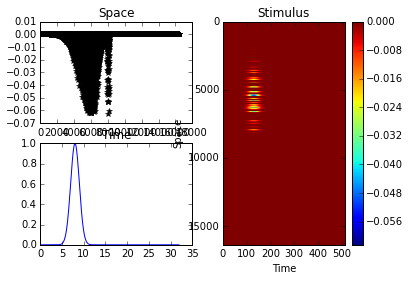

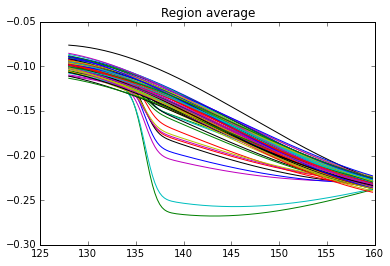

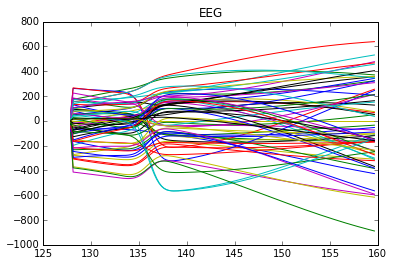

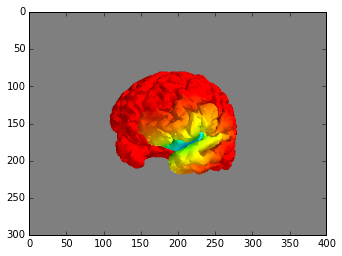

In [31]:
#Plot the stimulus
plot_pattern(sim.stimulus)

if IMPORTED_MAYAVI:
    surface_pattern(sim.surface, sim.stimulus.spatial_pattern)

#Make the lists numpy.arrays for easier use.
TAVG = numpy.array(tavg_data)
SAVG = numpy.array(savg_data)
EEG = numpy.array(eeg_data)

#Plot region averaged time series
figure(3)
plot(savg_time, SAVG[:, 0, :, 0])
title("Region average")

#Plot EEG time series
figure(4)
plot(eeg_time, EEG[:, 0, :, 0])
title("EEG")

#Show them
show()

if IMPORTED_MAYAVI:
    from tvb.simulator.plot.tools import mlab
    st = surface_timeseries(sim.surface, TAVG[:, 0, :, 0])
    imshow(mlab.screenshot())
